In [ ]:
%autosave 0
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import torch
import corner

# A (brief) tutorial on [Pyro](https://pyro.ai/)

Pyro can be used to perform MCMC and/or approximate inference for intractable posteriors

We can use Pyro to move from point estimates to posteriors in our **torch-based model**

In [ ]:
import pyro
display(pyro.__version__)
pyro.set_rng_seed(12345) # For reproducibility

## Distributions and random variables in pyro

Distributions in Pyro are implemented in [`pyro.distributions`](http://docs.pyro.ai/en/stable/distributions.html)

Let's start by creating a normal distribution. The `Normal` object expects its location $\mu$ and scale $\sigma$ as arguments

In [ ]:
from pyro.distributions import Normal

w_prior = Normal(loc=torch.tensor(0.), 
                 scale=torch.tensor(1.))

We can draw random sample from this object

In [ ]:
# Get 1000 samples 
samples = w_prior.rsample(sample_shape=(1000, )) # Reparameterized sampling
display(samples.shape)

# Build an histogram
fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
plt.hist(samples.detach().numpy(), bins=20, density=True)
# Plot the pdf
w_plot = np.linspace(-3, 3, num=100)
w_pdf = torch.exp(w_prior.log_prob(torch.from_numpy(w_plot))).detach().numpy()
plt.plot(w_plot, w_pdf, 'k-', lw=2);

We can also compute statistical descriptors from the object

In [ ]:
#mean
display(w_prior.mean)
#standard deviation
display(w_prior.stddev)
#entropy
display(w_prior.entropy())

**A note on the `shape` of pyro tensors**

In `pytorch` the shape of a tensor is a tuple with the size of each of its dimensions

In comparison `pyro` distributions have two shapes

- `event_shape` refers to the dimensionality of the distribution, e.g. normal (number), multivariate normal (vector), Cholesky (matrix), etc. Is used to denote dependent random variables
- `batch_shape` refers to a batch of distributions. Is used to denote conditionally independent random variables

The "final shape" of a tensor sampled from a `pyro` distribution will be a combination of both

In most cases we will assume independence between observations (batch dimension) and depedence between our model parameters (event dimension)

Distributions have an attribute called `to_event` which converts indepedent dimensions to dependent ones

**Example**

The following tells `pyro` that the two components of this bivariate normal distribution are independent 

In [ ]:
# Two conditionally independent normal RVs
w_prior = Normal(torch.tensor([[0., 2.]]), torch.tensor([[1., 1.]]))
display(w_prior.batch_shape, 
        w_prior.event_shape,
        w_prior.rsample().shape)

The following tells pyro to expect dependence between the components. We can interprete it as a multivariate normal with diagonal covariance

In [ ]:
w_prior = Normal(torch.tensor([[0., 2.]]), torch.tensor([[1., 1.]])).to_event(1)

display(w_prior.batch_shape, 
        w_prior.event_shape,
        w_prior.rsample().shape)

**Random variables in Pyro**

To create random variables that we can track within a model we use the [`pyro.sample`](http://pyro.ai/examples/intro_part_i.html#The-pyro.sample-Primitive) primitive

`pyro.sample` expects a name and an object from [`pyro.distributions`](http://docs.pyro.ai/en/stable/distributions.html)

For example, to create a variable named "w" with the previously defined distribution

$$
\begin{align}
w \sim &\mathcal{N}(\mu, \sigma^2) \nonumber \\
&\mu = \begin{pmatrix}0 \\ 2 \end{pmatrix}, \sigma = \begin{pmatrix} 1 \\ 1 \end{pmatrix} \nonumber
\end{align}
$$

we would write the generative model as

In [ ]:
def model():
    return pyro.sample(name='w', fn=w_prior)

And each time we run `model` a random sample is returned

In [ ]:
for i in range(10):
    print(model())

## Bayesian linear regression in pyro

Let's consider the linear regression problem

$$
y_i = f_\theta(x_i) + \epsilon = w x_i + b + \epsilon, \forall i
$$

with our previous assumptions

- $w$ and $b$ are random variables with normal priors
- $y$ is a random variable with normal distribution (likelihood)
- $x$ is a deterministic variable
- We have $N$ tuples $(x,y)$

The generative process is then

1. Choose hyperparameters: $\mu_w, \sigma_w, \mu_b, \sigma_b, \sigma_\epsilon$
1. Sample: $w \sim \mathcal{N}(\mu_w, \sigma_w^2)$
1. Sample: $b \sim \mathcal{N}(\mu_b, \sigma_b^2)$
1. For each $i=1,2,\ldots, N$
    1. Sample: $y_i \sim \mathcal{N}(w x_i + b, \sigma_\epsilon^2)$

which is often summarized using plate notation diagrams

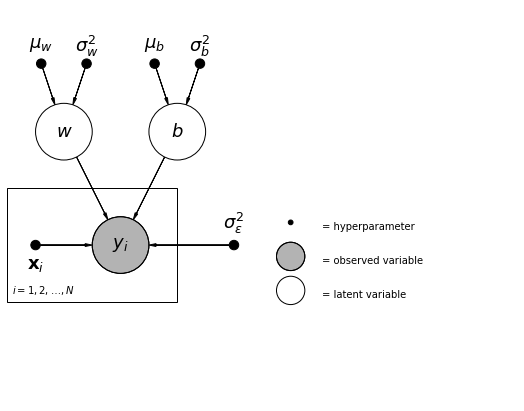

**Coding the model**

There are two ways to code the generative model in `pyro`

The first is to use an unconditioned model and the pass the data with  `pyro.condition`

In [ ]:
def model(x):
    w = pyro.sample("w", Normal(0.0, 10.0))
    b = pyro.sample("b", Normal(0.0, 10.0))
    with pyro.plate('dataset', size=len(x)):
        return pyro.sample("y", Normal(x*w + b, 1.0))

def conditioned_model(x, y):
    return pyro.condition(model, data={"y": y})(x)

The second is more direct. A random variable acting as the likelihood can be given the data through its `obs` argument

In [ ]:
from pyro.distributions import Uniform

def model_obs(x, y=None):  
    w = pyro.sample("w", Normal(0.0, 10.0))
    b = pyro.sample("b", Normal(0.0, 10.0))
    # s = pyro.sample("s", Uniform(0.01, 10.0))    
    with pyro.plate('dataset', size=len(x)):
        return pyro.sample("y", Normal(x*w + b, 1.), obs=y)

In both cases the primitive [`pyro.plate`](http://docs.pyro.ai/en/stable/primitives.html#pyro.plate) is used for vectorized conditioning with the whole dataset 

The plate expects a name and the size of the dataset


## Sampling based Inference: MCMC

With the model set we move on inferring the posterior of its parameters and predictions using `pyro`

First we will review Markov Chain Monte Carlo (MCMC) to perform sampling based inference. MCMC methods return samples from a markov chain that converges to the posterior we care. We will focus on the practical implementation of MCMC using `pyro`. For more deep theoretical details on MCMC see Barber Chapter 27, [here](https://github.com/magister-informatica-uach/INFO337/tree/master/MCMC) or [here](https://github.com/phuijse/INFO274)

The main wrapper for [MCMC methods in pyro](https://docs.pyro.ai/en/stable/mcmc.html) is 

```python
pyro.infer.MCMC(kernel, # A sampler algoritm that decides the transitions
                num_samples, # Number of samples excluding the warmup ones
                warmup_steps=None, # Samples to discard in the beginning
                initial_params=None, # If not specified they are sampled from the prior
                num_chains=1, # Can run parallel chains
                disable_validation=True, # Divergent transitions checks
                ... # Only the most critical arguments are shown here
               )
``` 

The main methods of MCMC are

- `run()`: Populates the chain, expects the same arguments as `model`
- `diagnostics()`: Gives useful metrics to assess convergence
- `summary()`: Returns a table with the statistics of the model parameters
- `get_sample()`: Returns the posterior samples

The currently available kernels are `HMC` (Hamiltonian Monte Carlo) and `NUTS` (No-U turn sampler). Both can deal with continous parameters. NUTS sets its step size automatically and is currently the state of the art. All kernels expects the function that specifies generative model plus their own particular arguments

Let's run MCMC with NUTS for the Here we run MCMC as a reference

In [ ]:
from pyro.infer import MCMC, NUTS

sampler = MCMC(kernel=NUTS(model_obs, adapt_step_size=True), 
               num_chains=1, num_samples=1000, warmup_steps=100)

# Create some data and run the chain
x = torch.tensor([-2., 2.])
y = x
# x = torch.randn(10)
# y = 2*x -1 + 0.5*torch.randn(len(x))
sampler.run(x, y)

Plot the statistical moments, $\hat r$ statistic and 90% credibility interval

In [ ]:
sampler.summary(prob=0.9)

Get the samples and visualize the posterior

In [ ]:
samples = sampler.get_samples()

figure = corner.corner(np.stack((samples['b'].detach().numpy() , 
                                 samples['w'].detach().numpy() )).T, 
                       smooth=1., bins=20, quantiles=[0.16, 0.5, 0.84], 
                       labels=["b", "w"], show_titles=True, title_kwargs={"fontsize": 12})

To obtain the posterior predictive of $y$ given $x$ we can use the utility class [`pyro.infer.Predictive`](http://docs.pyro.ai/en/stable/inference_algos.html#pyro.infer.predictive.Predictive)

```python
pyro.infer.Predictive(model, # Model function
                      num_samples=None, # How many samples to draw
                      return_sites=(), # Which parameters to draw
                      parallel=False, # Vectorized sampling
                      posterior_samples=None, # Samples from the Markov Chain
                      guide=None # Omit this for the moment
                     )
```

If `posterior_samples` is provided then `samples.num_samples` will be generated regardless of what is specified by the `num_samples` argument

In [ ]:
# Create the object
predictive = pyro.infer.Predictive(model_obs, 
                                   return_sites=("w", "b", "y"),
                                   posterior_samples=sampler.get_samples())

# Evaluate on test data
x_test = np.linspace(-5, 5, num=100).astype('float32') 
predictive_samples = predictive(torch.from_numpy(x_test))

# Plot it
med = predictive_samples["y"].median(axis=0).values.numpy()
qua = predictive_samples["y"].quantile(torch.tensor([0.05, 0.95]), axis=0).numpy()

fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)
ax.plot(x_test, med)
ax.fill_between(x_test, qua[0], qua[1], alpha=0.5);

ax.errorbar(x.numpy(), y.numpy(), xerr=0, 
            yerr=2,
            #yerr=2*samples['s'].mean().detach().numpy(), 
            fmt='none', c='k', zorder=100);

**Activity**

- Add a prior to $\sigma_\epsilon$
- Train the chain with more data
- Add hyperpriors